In [1]:
import scipy.stats as stats

In [2]:
import torch

$$\begin{align}
    p(z|\alpha, \beta) &= \frac{\beta^\alpha}{\Gamma(\alpha)}z^{\alpha - 1}\exp(-\beta z)\\
    &= \frac{\beta^\alpha}{\Gamma(\alpha)}\exp\big(({\alpha - 1})\log(z) -\beta z\big)\\
    &= \frac{\beta^\alpha}{\Gamma(\alpha)}\exp\big(-[\beta z -({\alpha - 1})\log(z) ]\big)
\end{align}$$

In [3]:
alpha, beta = 9, 2

def E(q):
    # return 0.5 * (q-0.5)**2  # gaussian
    return beta * q - (alpha - 1) * torch.log(q)  # gamma

def dE(q):
    # return (q-0.5)  # gaussian
    return -(alpha - 1) / q + beta   # gamma

def dX_dt(X, t=0):
    """
    """
    q, p = X
    grad = torch.Tensor([
         p,
        -dE(q)
    ])
    return grad

def leapfrog(q, p, dE, nsteps=200, eps=1e-3):
    steps = [[q, p]]
    for _ in range(nsteps):
        p = p - eps / 2 * dE(q)
        q = q + eps * p
        p = p - eps / 2 * dE(q)
        steps.append([q, p])
    steps = torch.Tensor(steps)    
    return steps

def H(q, p):
    """
    The Hamiltonian
    """
    return E(q) + p ** 2 / 2

In [12]:
q, p = 1, 1
eps = 1e-1

n_samples = 1000
all_steps = []
q_samples = []

for ix in range(n_samples):
    steps = leapfrog(q, p, dE, 25, eps)
    current, proposed = steps[[0, -1]]
    
    # The accepted-rejected criterion
    m_criterion = min(1, torch.exp(H(*current) - H(*proposed)))
    u = torch.rand(1)
    if m_criterion > u:
        q, _ = proposed
        q_samples.append(q)
        all_steps.append(steps)

    p = torch.randn(1)

In [13]:
q_samples = torch.Tensor(q_samples)

/Users/wangyulong/anaconda3/envs/py3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


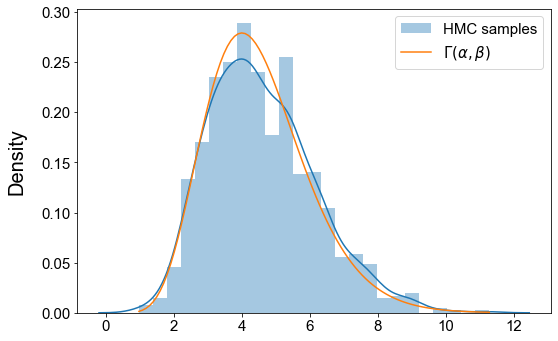

In [24]:
plt.figure(figsize=(8, 5))
sns.distplot(q_samples, label='HMC samples')

G = stats.gamma(a=alpha, scale=1/beta)
xrange = np.linspace(q_samples.min().item(), q_samples.max().item(), 100)
plt.plot(xrange, G.pdf(xrange), label=r"$\Gamma(\alpha,\beta)$")
plt.legend(loc=1)